In [1]:
import torch
import sys
sys.path.extend(['..'])
from mvn import MVNIso as MVN
from distributions import log_prob_banana as log_p
from samplers.stams import stams_importance_sampling, log_psi_stams
import matplotlib.pyplot as plt
from util import ess
from math import log, pi, sqrt
import time
from pathlib import Path
from tqdm import tqdm
%matplotlib inline

For visualization purposes, make a discrete grid of x, y and compute the $p(x)$ density on it

In [2]:
x = torch.linspace(-4, 4, 201)
xx, yy = torch.meshgrid(x, x)
xy = torch.stack([xx.flatten(), yy.flatten()], dim=0)
log_p_grid = log_p(xy)
p_grid = (log_p_grid - torch.logsumexp(log_p_grid.flatten(), dim=0)).exp().reshape(xx.size())

Run HMC over $\theta$ for a variety of different $\lambda_{KL}$ values

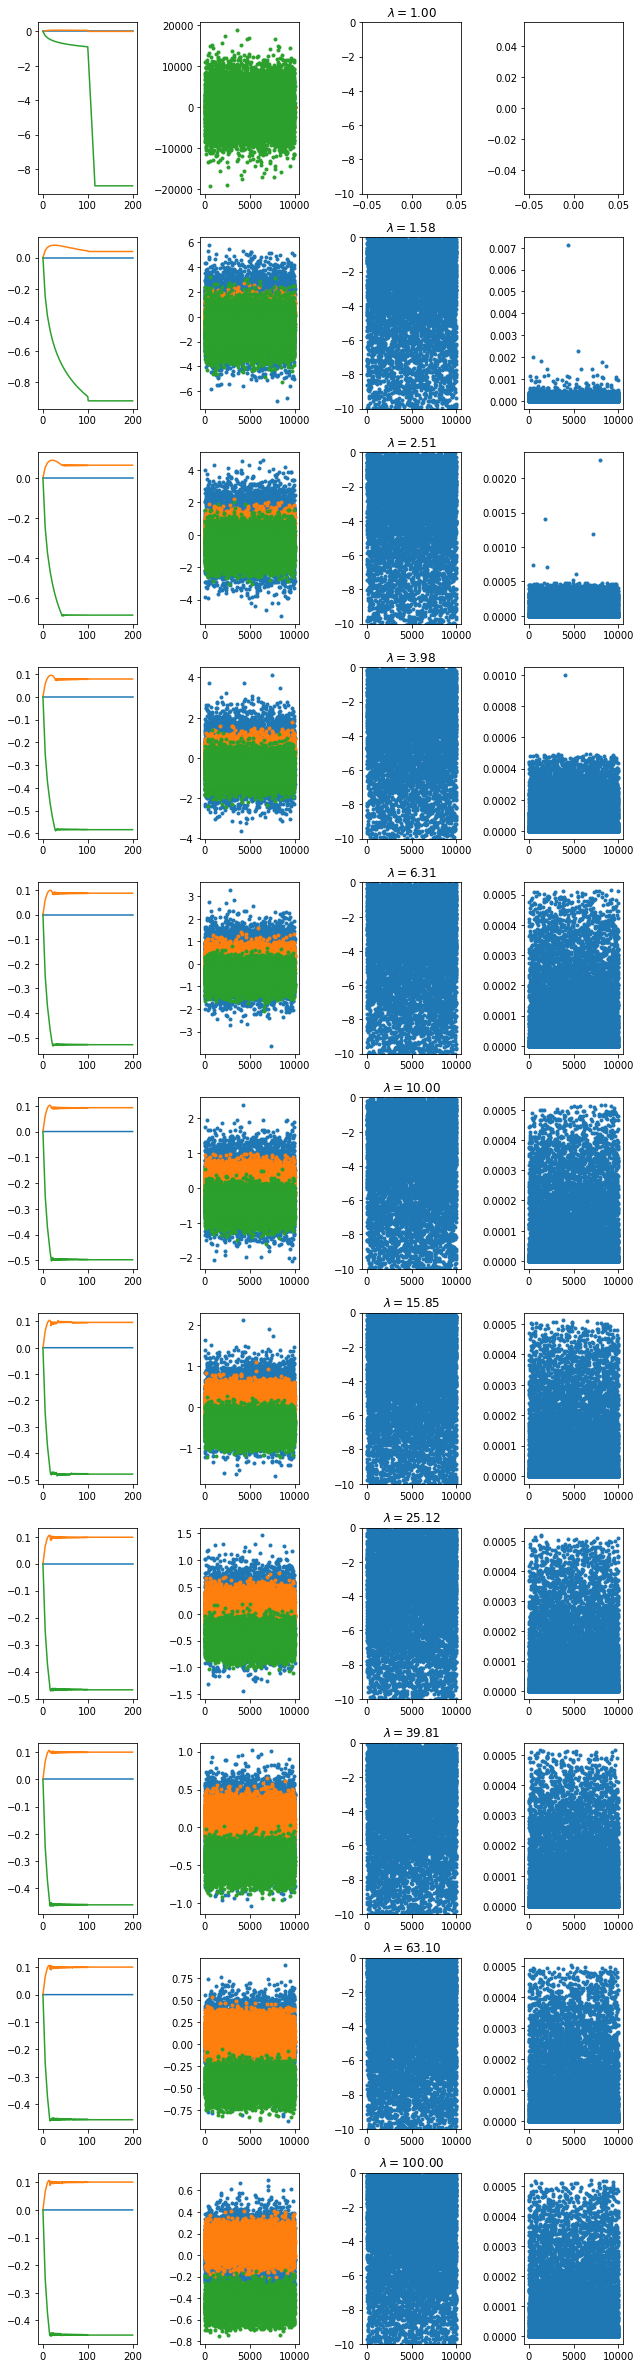

In [3]:
lambdas = torch.logspace(0, 2, 11)
results = []
qi = MVN(d=2)
fig, ax = plt.subplots(len(lambdas), 4, figsize=(9,3*len(lambdas)))
for i, l in enumerate(lambdas):
    save_file = Path('results') / f"mi_kl_is_lam={l.item():.3f}.dat"
    if save_file.exists():
        data = torch.load(save_file)
    else:
        data = {'results': stams_importance_sampling(log_p, lam_kl=l, q_init=qi, n_samples=10000, n_kl_quad=5)}
        torch.save(data, save_file)
    results.append(data['results'])

    ax[i, 0].plot(data['results']['th_optim'])
    ax[i, 1].plot(data['results']['samples'], '.')
    ax[i, 2].plot(data['results']['log_psi']-data['results']['log_psi'].max(), '.')
    ax[i, 2].set_ylim([-10, 0])
    ax[i, 2].set_title(f'$\lambda=${l:.2f}')
    ax[i, 3].plot(data['results']['weights'], '.')
fig.tight_layout()

Inspect some metadata like acceptance ratio and effective sample size per $\lambda$

TODO - run a few chains and use rhat for convergence tests

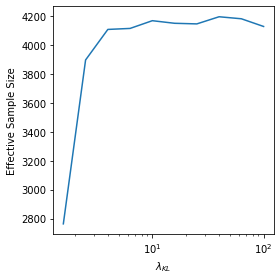

In [4]:
ess_values = torch.tensor([r['ess'] for r in results])

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.semilogx(lambdas, ess_values)
ax.set_xlabel(r'$\lambda_{KL}$')
ax.set_ylabel('Effective Sample Size')

fig.tight_layout()

Compute $E[KL]$ and Stams-approximation to $MI$ for each $\lambda$

In [5]:
def expected_kl(log_p, theta_samples, weights):
    q = MVN(d=2)
    avg_kl = 0.
    net_w = 1e-20
    for th, w in tqdm(zip(theta_samples, weights), desc='E[KL]', total=theta_samples.size(0), leave=False):
        q.set_theta(th)
        if torch.isnan(w):
            continue
        avg_kl += (-q.entropy() - q.quadrature_ev(log_p, n=5))*w
        net_w += w
    return avg_kl / net_w

def _ent_psi_hat_helper(q, hess_log_psi):
    return log(2*pi)*q.n_params/2 - 0.5*torch.logdet(q.fisher() - hess_log_psi)

def stams_mi(log_p, lam_kl, theta_samples, weights):
    q = MVN(d=2)
    avg_neg_log_psi = 0.
    avg_ent_psi_hat = 0.
    net_w = 1e-20
    for th, w in tqdm(zip(theta_samples, weights), desc='MI', total=theta_samples.size(0), leave=False):
        q.set_theta(th)
        log_psi, _, hess_log_psi = log_psi_stams(log_p, lam_kl, q, include_grad=True, include_hess=True)
        ent_psi_hat = _ent_psi_hat_helper(q, hess_log_psi)
        if torch.isnan(w) or torch.isnan(ent_psi_hat):
            continue
        avg_neg_log_psi -= log_psi * w
        avg_ent_psi_hat += ent_psi_hat * w
        net_w += w
    return avg_neg_log_psi/net_w - avg_ent_psi_hat/net_w


ekl_values = torch.zeros(lambdas.size())
mi_values = torch.zeros(lambdas.size())
for i, (l, r) in enumerate(zip(lambdas, results)):
    ekl_values[i] = expected_kl(log_p, r['samples'][::10], r['weights'][::10]) 
    mi_values[i] = stams_mi(log_p, l, r['samples'][::10], r['weights'][::10])

In [11]:
logdet_fisher_values = torch.zeros(lambdas.size())
logdet_total_values = torch.zeros(lambdas.size())
ent_psi_values = torch.zeros(lambdas.size())
q = MVN(d=2)
for i, (l, r) in enumerate(zip(lambdas, results)):
    valid = ~torch.isnan(r['weights'])
    ent_psi_values[i] = -torch.sum(r['log_psi'][valid] * r['weights'][valid]) / r['weights'][valid].sum()
    wt_tot = 0
    for th, w in tqdm(zip(r['samples'][::10], r['weights'][::10]), total=1000, leave=False):
        q.set_theta(th)
        _, _, hess_log_psi = log_psi_stams(log_p, l, q, include_grad=True, include_hess=True)
        logdet_tot = torch.logdet(q.fisher() - hess_log_psi)
        if torch.isnan(logdet_tot) or torch.isnan(w):
            continue
        logdet_total_values[i] += logdet_tot * w
        logdet_fisher_values[i] += q.log_det_fisher() * w
        wt_tot += w
    logdet_total_values[i] /= wt_tot
    logdet_fisher_values[i] /= wt_tot

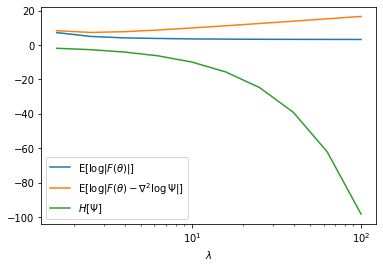

In [12]:
plt.semilogx(lambdas, logdet_fisher_values)
plt.semilogx(lambdas, logdet_total_values)
plt.semilogx(lambdas, ent_psi_values)
plt.xlabel('$\lambda$')
plt.legend([r'E[$\log|F(\theta)|$]', r'E[$\log|F(\theta)-\nabla^2\log\Psi|$]', r'$H[\Psi]$'])
plt.show()

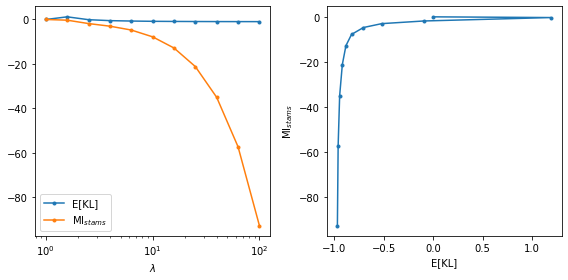

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].semilogx(lambdas, ekl_values, marker='.')
ax[0].semilogx(lambdas, mi_values, marker='.')
ax[0].set_xlabel('$\lambda$')
ax[0].legend(['E[KL]', 'MI$_{stams}$'])

ax[1].plot(ekl_values, mi_values, marker='.')
ax[1].set_xlabel('E[KL]')
ax[1].set_ylabel('MI$_{stams}$')

fig.tight_layout()